In [170]:
#libraries for clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [255]:
df = pd.read_csv("B.HEALTH_classification.csv")
base_df = df.drop(columns=["subject", "day", "sleep onset latency (minutes)", "label"])

In [256]:
def cluster_ac(x, n_clusters):
    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ac.fit(x)
    return ac.labels_

In [257]:
def cluster_DBSCAN(x, eps):
    db = DBSCAN(metric='euclidean', eps=eps)
    db.fit(x)
    return db.labels_

In [258]:
def cluster_kmeans(x, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=17).fit(x)
    return kmeans.labels_

In [259]:
def normalize_data(x, how='minmax'):
    match how:
        case 'minmax':
            scaler = MinMaxScaler()
            return scaler.fit_transform(x)
        case 'standard':
            scaler = StandardScaler()
            return scaler.fit_transform(x)
        case 'none':
            return x

In [260]:
def reduce_df(X, n_components=2, how='pca'):
    match how:
        case 'pca':
            redux = PCA(n_components)
            return redux.fit_transform(X)
        case 'tsne':
            redux = TSNE(n_components)
            return redux.fit_transform(X)
        case 'none':
            return X

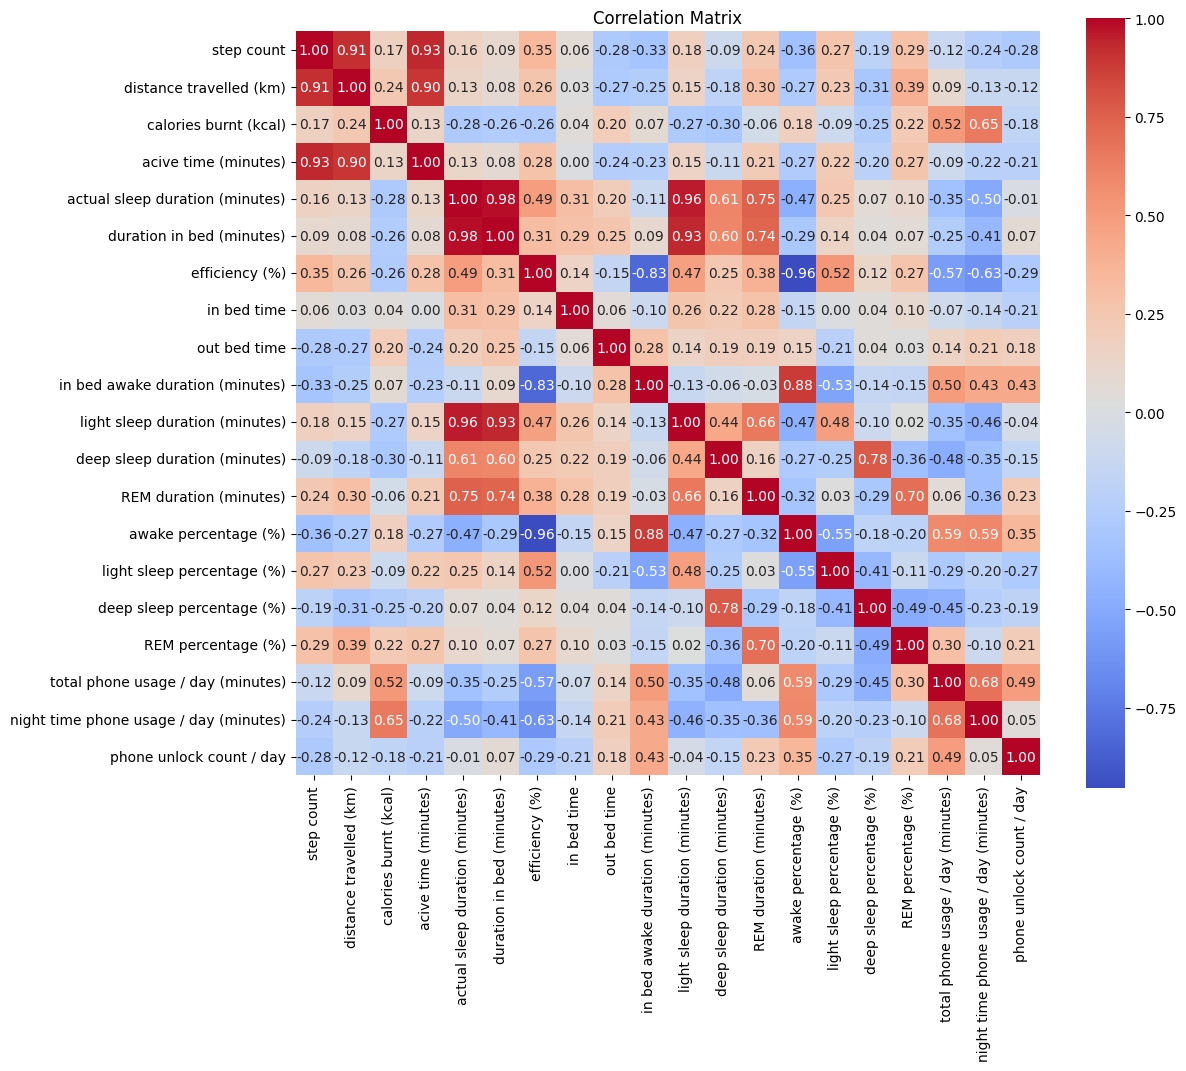

In [261]:
# Plot correlation matrix
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", square=True, cbar=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# Call the function to plot the correlation matrix
plot_correlation_matrix(base_df)

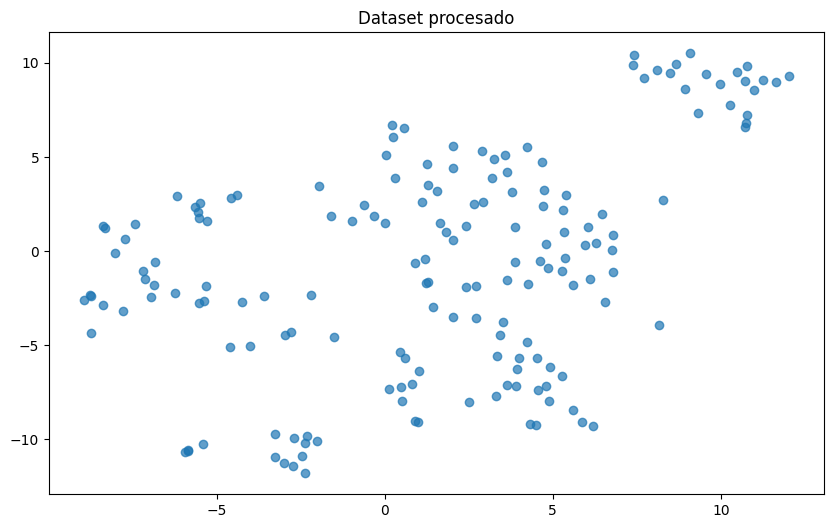

In [262]:
# Normalize the dataset
x_normalized = normalize_data(base_df, how='minmax')

# Reduce dimensions using TSNE
x_reduced = reduce_df(x_normalized, n_components=10, how='pca')

x_reduced_plot = reduce_df(x_normalized, n_components=2, how='tsne')

# Scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced_plot[:, 0], x_reduced_plot[:, 1], alpha=0.7)
plt.title('Dataset procesado')
plt.show()

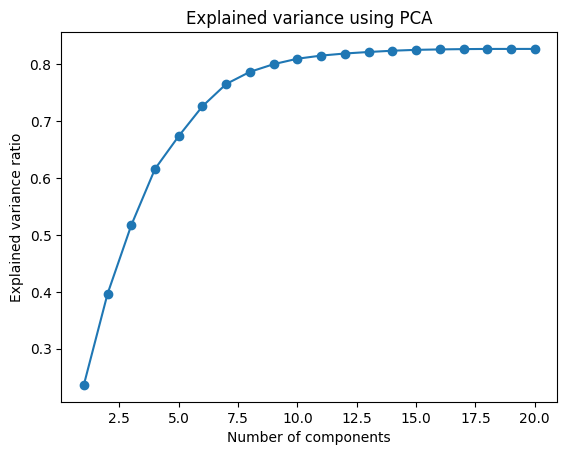

In [263]:
# Plot explained variance using PCA
pca = PCA(n_components=x_normalized.shape[1])
pca_reduced = pca.fit_transform(x_normalized)
plt.plot(range(1, x_normalized.shape[1] + 1), np.cumsum(pca.explained_variance_), marker='o')
plt.title('Explained variance using PCA')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

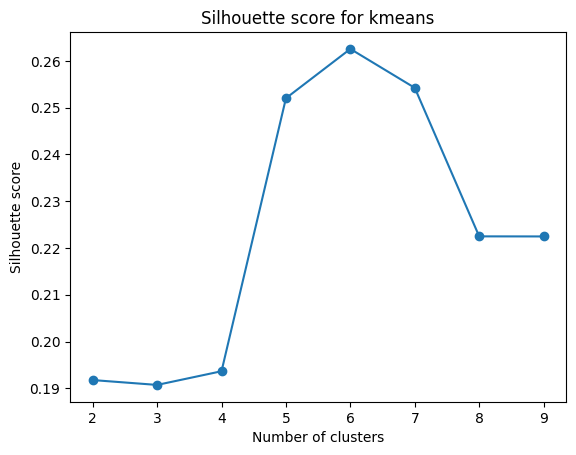

In [264]:
# Plot silhouette score for kmeans
silhouette_scores = []
for n_clusters in range(2, 10):
    kmeans_labels = cluster_kmeans(x_reduced, n_clusters=n_clusters)
    silhouette_avg = silhouette_score(x_reduced, kmeans_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette score for kmeans')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

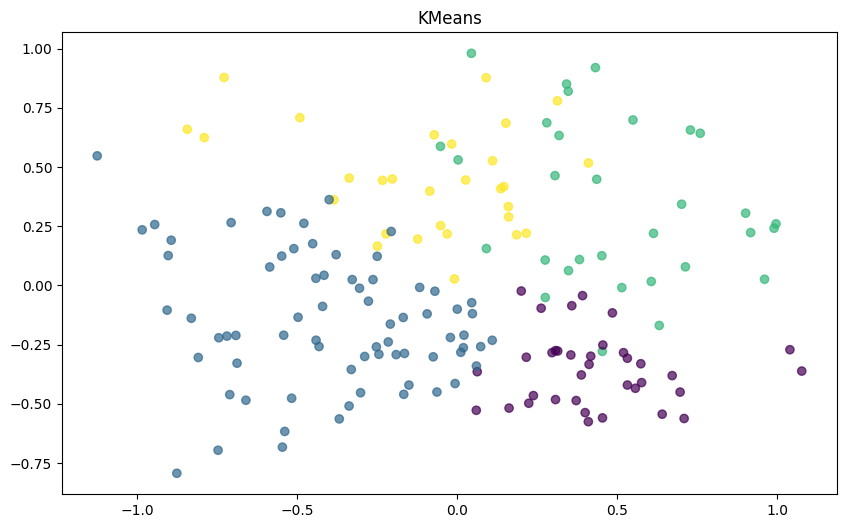

In [274]:
# Clusterize using KMeans
kmeans_labels = cluster_kmeans(x_reduced, n_clusters=4)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=kmeans_labels, alpha=0.7)
plt.title('KMeans')
plt.show()

In [275]:
# Copy base dataset, normalize values and add labels back
labeled_df = base_df.copy()
labeled_df = labeled_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
labeled_df['label'] = df['label']

In [276]:
# Print standard deviation and label count for each cluster
def print_cluster_stats(labeled_df, labels):
    for cluster_num in np.unique(labels):
        cluster_data = labeled_df[labels == cluster_num]
        cluster_data_plot = labeled_df.drop(columns=["label", "in bed time"])[labels == cluster_num]
        
        if cluster_num == -1:
            print("Noise: ", len(cluster_data), "instances")
            continue


        
        #std_dev = cluster_data.std()

        #plt.figure().set_figwidth(25)
        #plt.bar(std_dev.index, std_dev.values, align='center')
        #plt.title(f"Standard deviation for each variable in cluster {cluster_num}")
        #plt.xlabel("Variables")
        #plt.ylabel("Standard deviation")
        #plt.show()

        means = cluster_data_plot.mean()

        plt.figure().set_figwidth(60)
        plt.gca().set_ylim((0, 1))
        plt.bar(means.index, means.values, align='center')
        plt.title(f"Mean for each variable in cluster {cluster_num}")
        plt.xlabel("Variables")
        plt.ylabel("Mean")
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.show()

        #print(f"Cluster {cluster_num}:")
        #print("Variance for each variable:")
        #print(std_dev)
        print("\nLabel count:")
        print(cluster_data['label'].value_counts())

        print("\n")

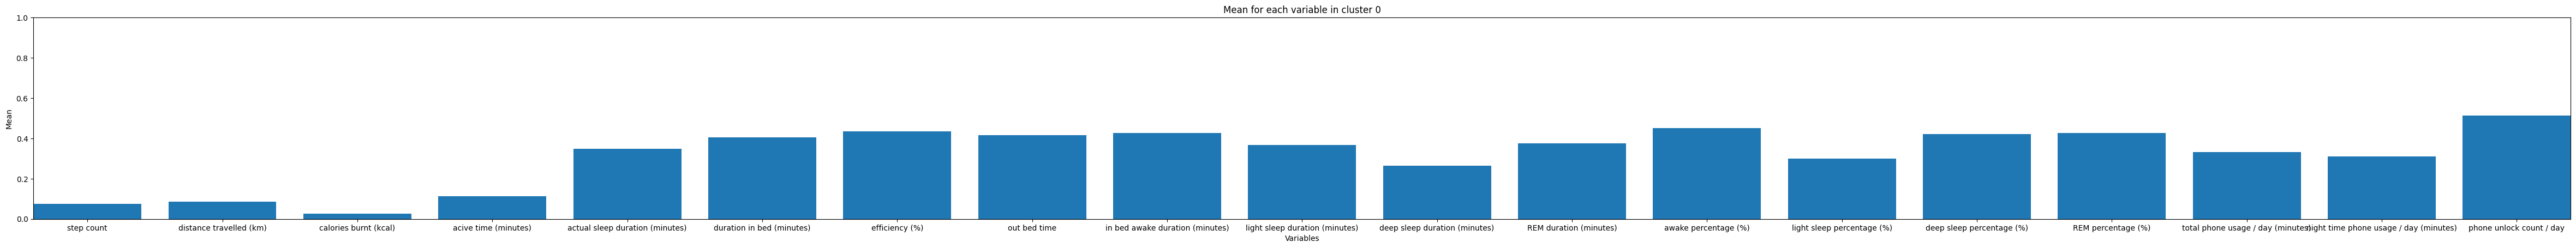


Label count:
label
1    32
2     4
Name: count, dtype: int64




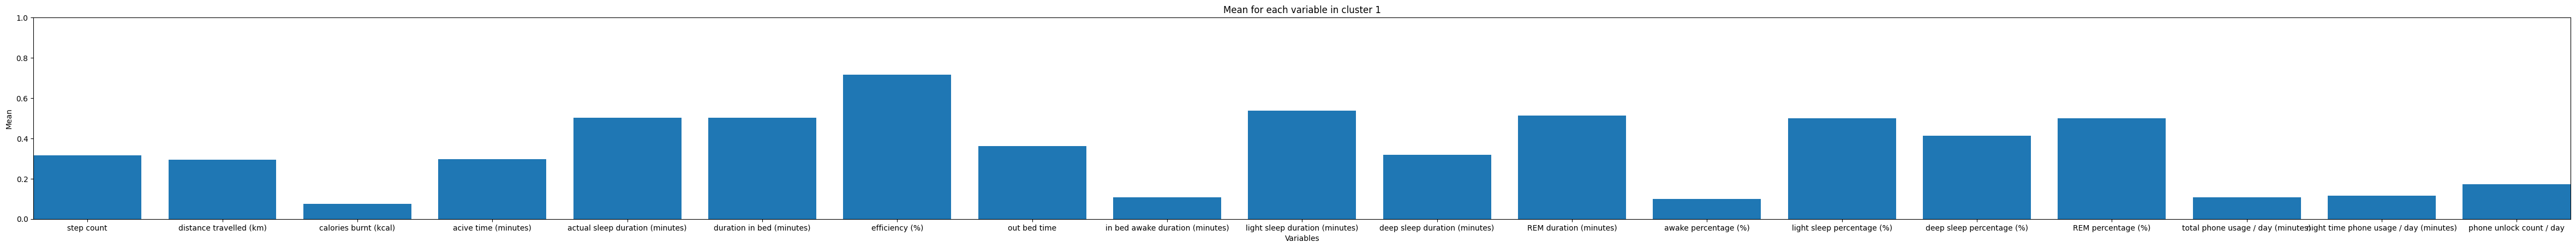


Label count:
label
0    54
1    18
Name: count, dtype: int64




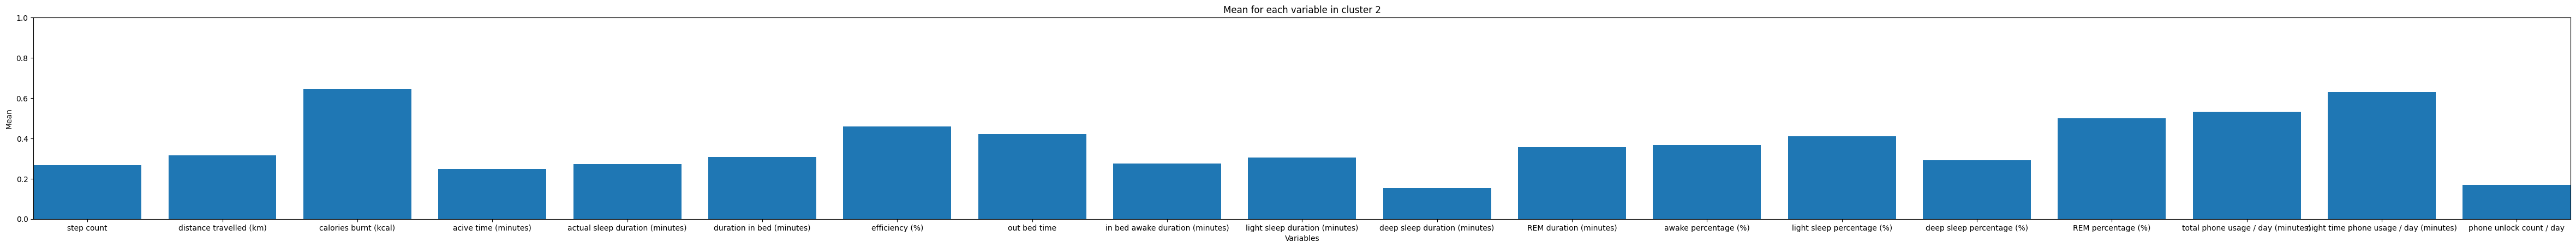


Label count:
label
1    24
2     4
0     3
Name: count, dtype: int64




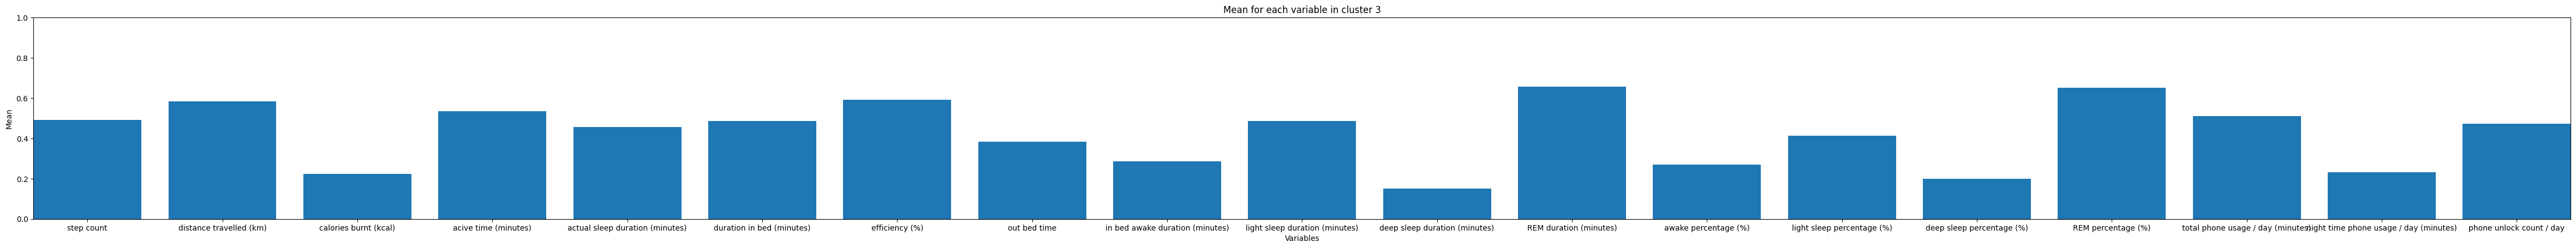


Label count:
label
0    15
1    14
Name: count, dtype: int64




In [277]:
print_cluster_stats(labeled_df, kmeans_labels)

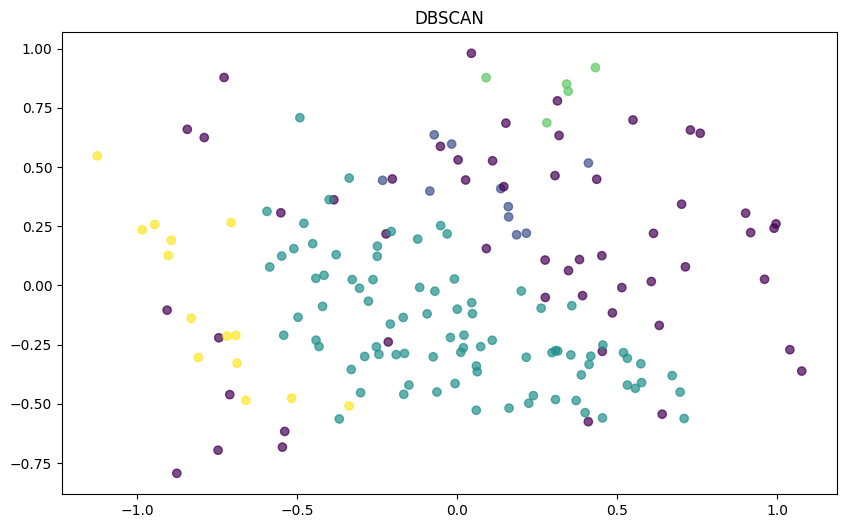

In [278]:
# Clusterize using DBSCAN
dbscan_labels = cluster_DBSCAN(x_reduced, 0.5)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=dbscan_labels, alpha=0.7)
plt.title('DBSCAN')
plt.show()

Noise:  53 instances


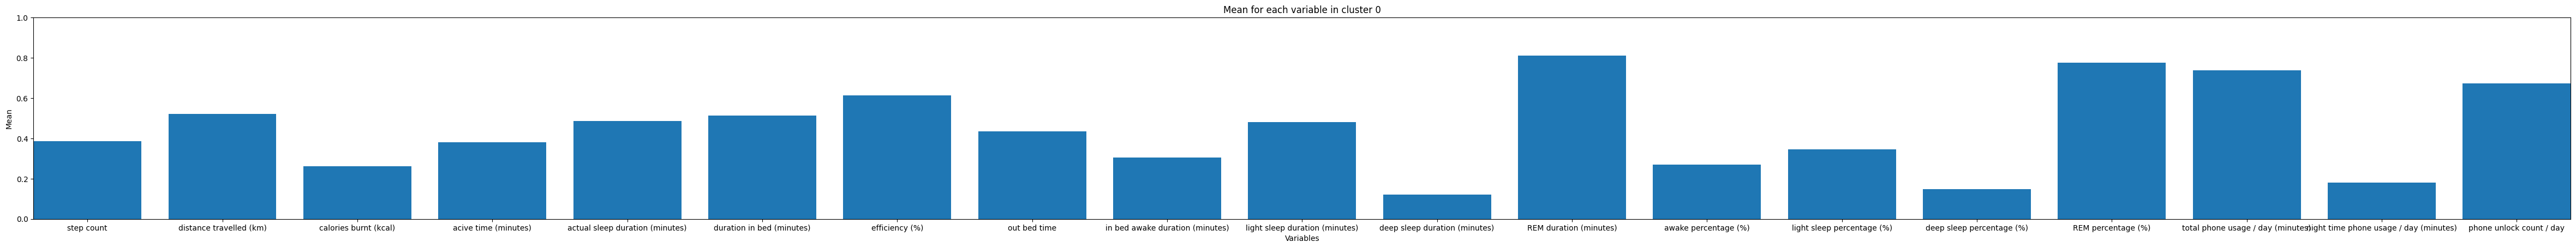


Label count:
label
1    6
0    4
Name: count, dtype: int64




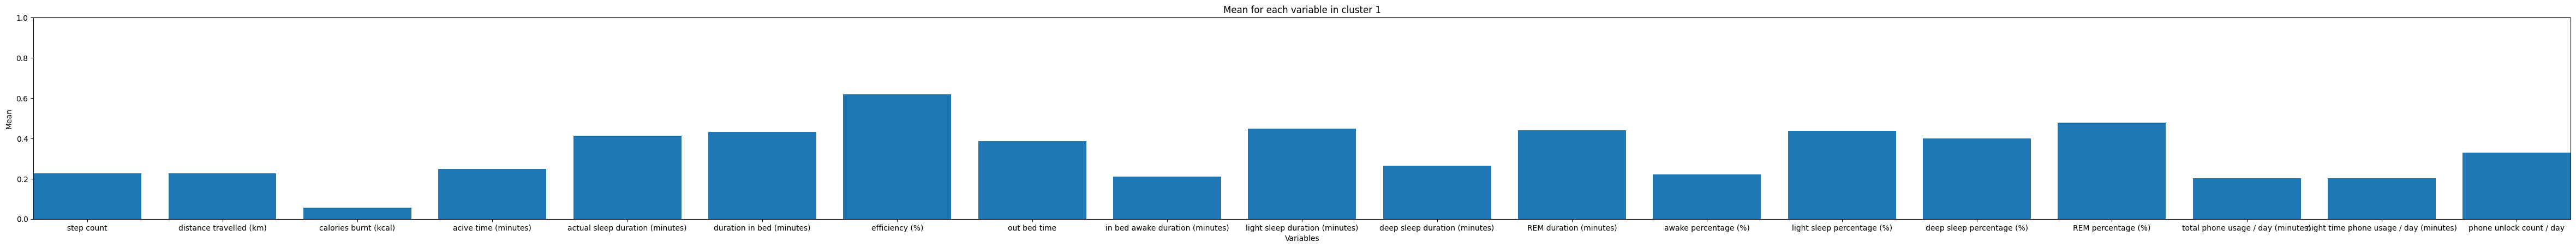


Label count:
label
1    42
0    42
2     2
Name: count, dtype: int64




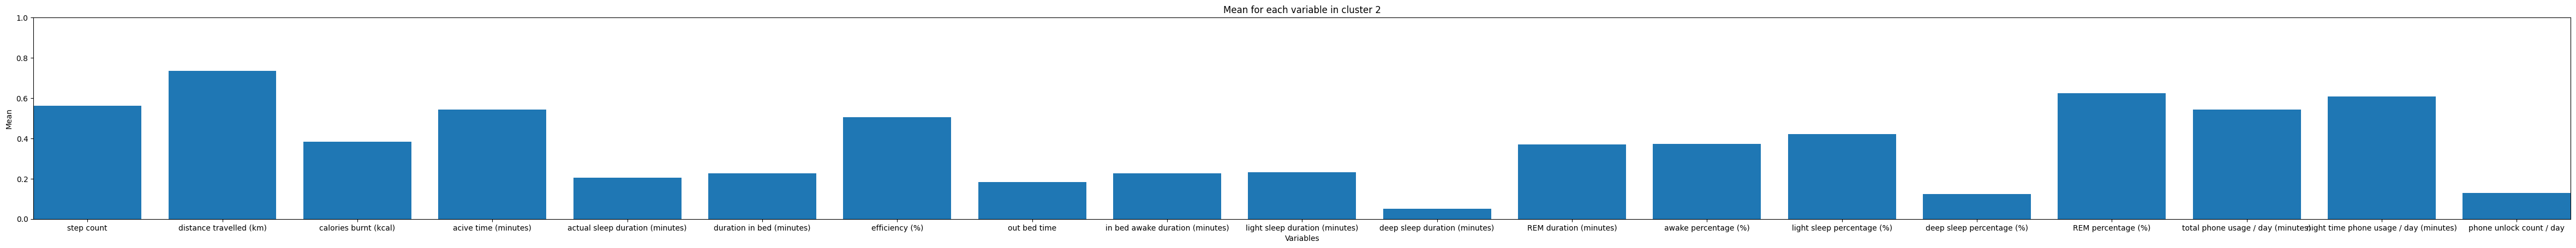


Label count:
label
1    5
Name: count, dtype: int64




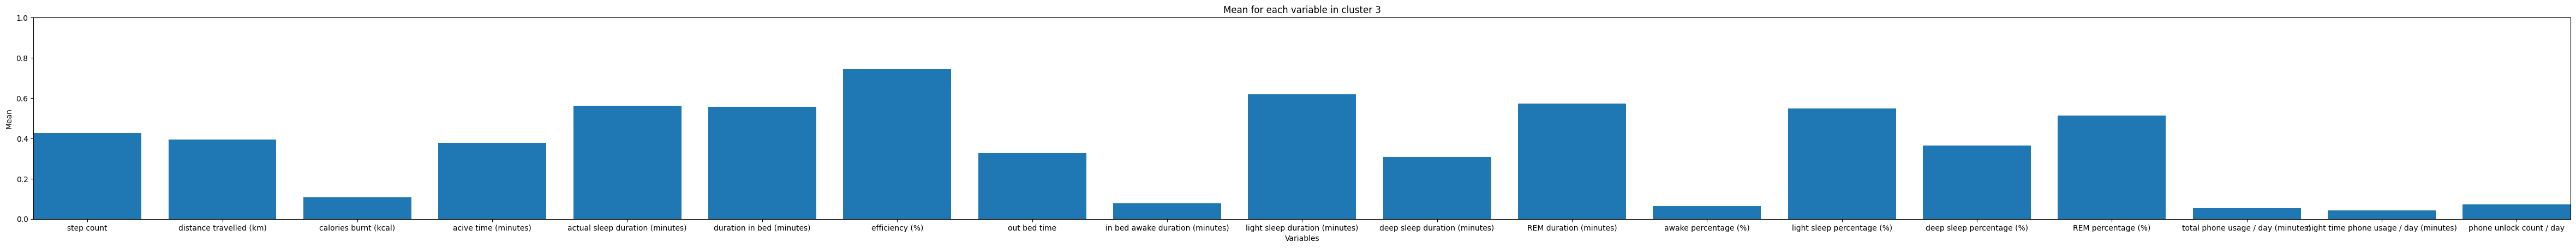


Label count:
label
0    13
1     1
Name: count, dtype: int64




In [279]:
print_cluster_stats(labeled_df, dbscan_labels)


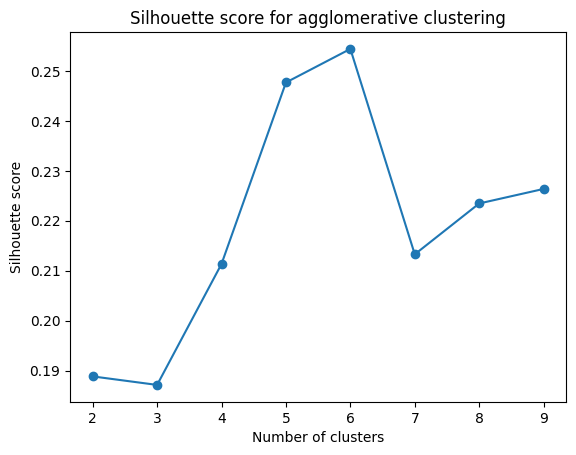

In [280]:
# Plot silhouette score for agglomerative clustering
silhouette_scores = []
for n_clusters in range(2, 10):
    agglomerative_labels = cluster_ac(x_reduced, n_clusters=n_clusters)
    silhouette_avg = silhouette_score(x_reduced, agglomerative_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette score for agglomerative clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

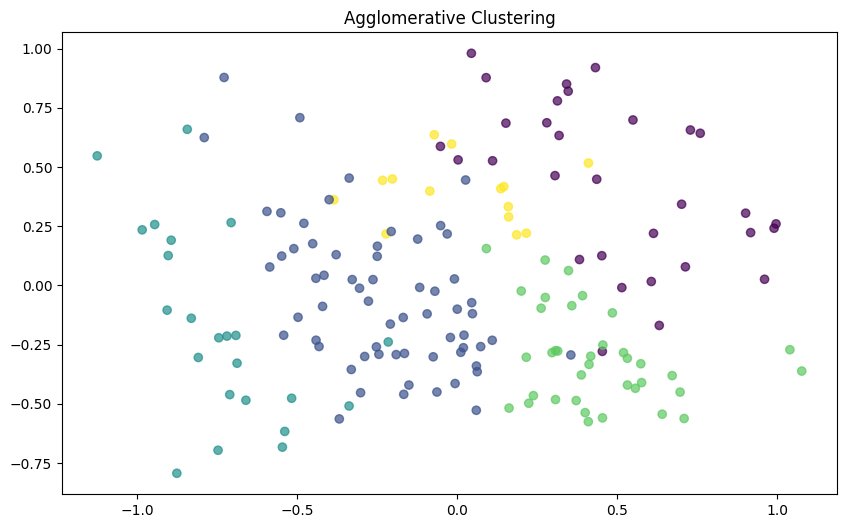

In [281]:
# Clusterize using agglomerative clustering
agglomerative_labels = cluster_ac(x_reduced, n_clusters=5)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=agglomerative_labels, alpha=0.7)
plt.title('Agglomerative Clustering')
plt.show()

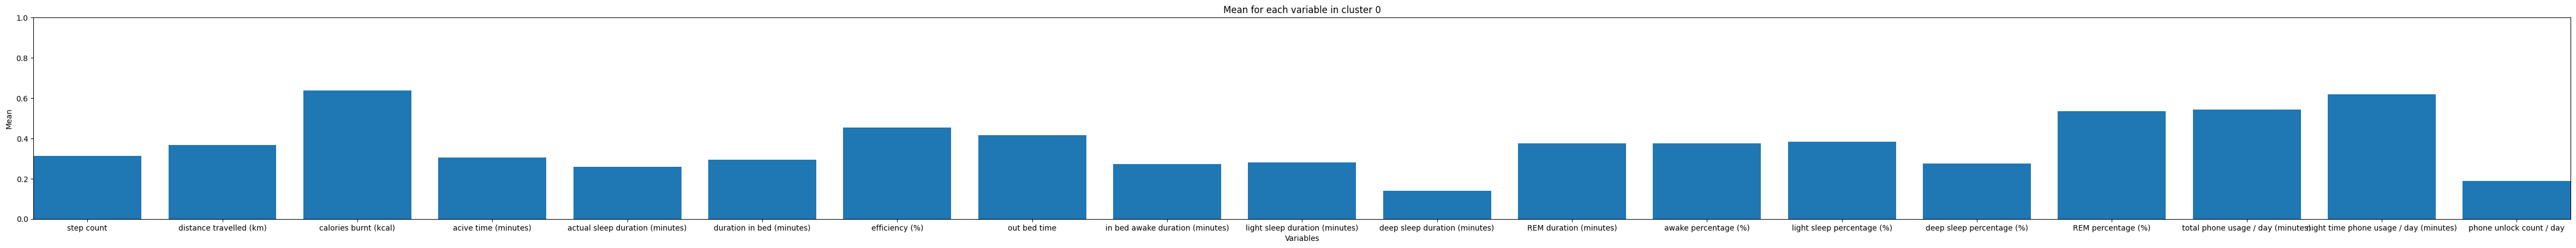


Label count:
label
1    24
2     4
0     3
Name: count, dtype: int64




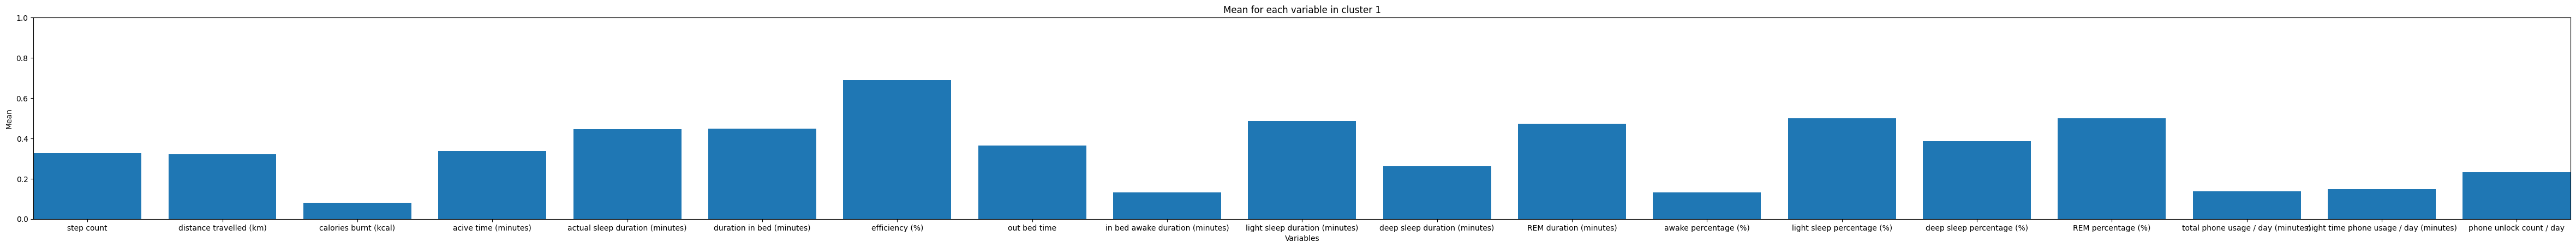


Label count:
label
0    46
1    17
Name: count, dtype: int64




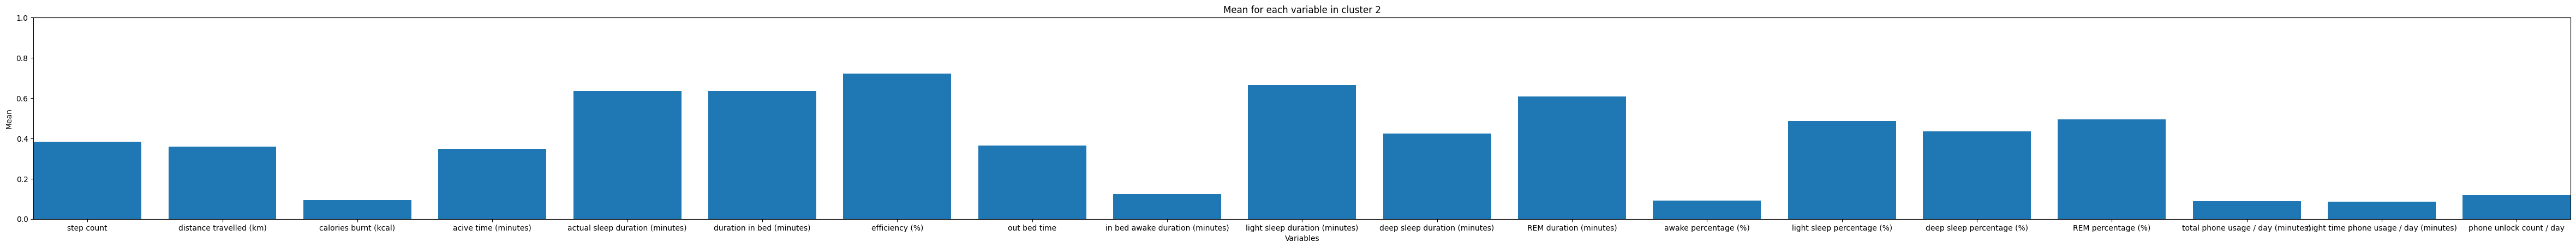


Label count:
label
0    17
1     6
Name: count, dtype: int64




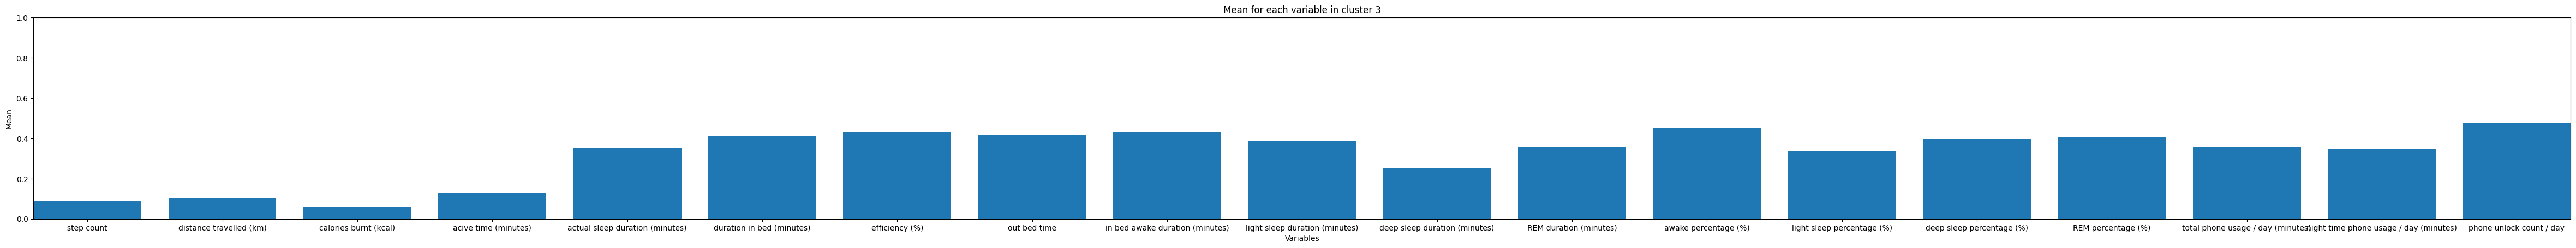


Label count:
label
1    33
2     4
Name: count, dtype: int64




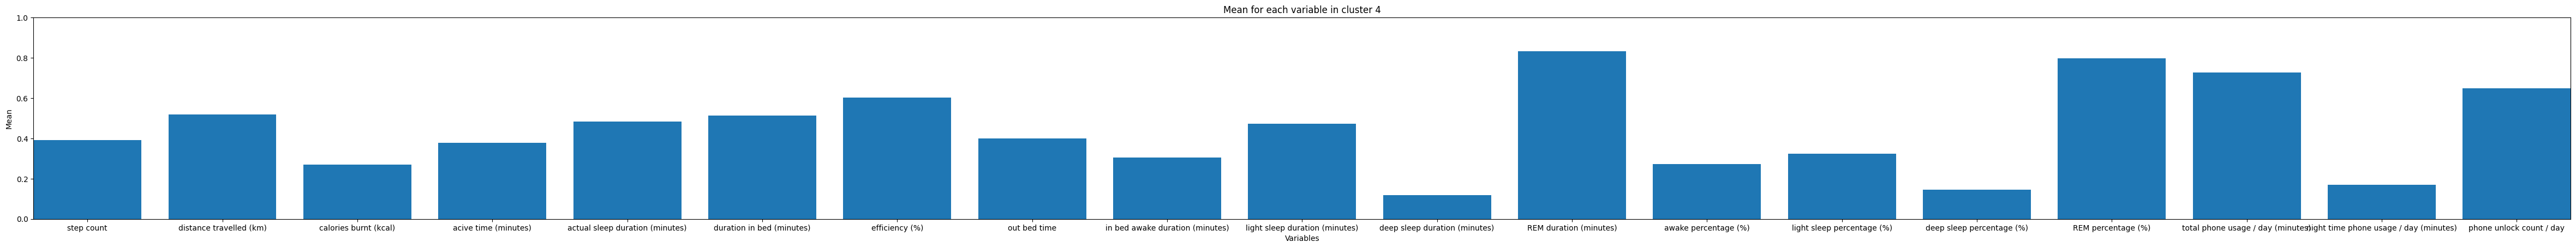


Label count:
label
1    8
0    6
Name: count, dtype: int64




In [282]:
print_cluster_stats(labeled_df, agglomerative_labels)